# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    numbers_words = [word for word in numbers_words if not word in stop_words]

    return numbers_words

# apply preprocessing
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

C:\Users\bvits\AppData\Local\Temp\ipykernel_10880\721748992.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)


In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## LDA

[['nasdaq', 'stock', 'nyse', 'inc', 'nvidia', 'shares', 'stocks', 'day', 'nvda', 'trade'], ['nasdaq', 'nyse', 'trade', 'china', 'year', 'index', 'stocks', 'shares', 'earnings', 'percent'], ['zacks', 'earnings', 'year', 'stocks', 'company', 'growth', 'rank', 'stock', 'quarter', 'nasdaq'], ['market', 'said', 'one', 'could', 'companies', 'week', 'also', 'like', 'last', 'new'], ['year', 'company', 'nvidia', 'quarter', 'nasdaq', 'million', 'billion', 'zacks', 'revenues', 'intel']]
Topic 0: nasdaq stock nyse inc nvidia shares stocks day nvda trade
Topic 1: nasdaq nyse trade china year index stocks shares earnings percent
Topic 2: zacks earnings year stocks company growth rank stock quarter nasdaq
Topic 3: market said one could companies week also like last new
Topic 4: year company nvidia quarter nasdaq million billion zacks revenues intel
[[3.83954251e-01 1.23810528e-01 6.20982425e-04 4.90993420e-01
  6.20818388e-04]
 [5.40097998e-01 9.67432420e-03 7.56229474e-04 4.48702896e-01
  7.68552565

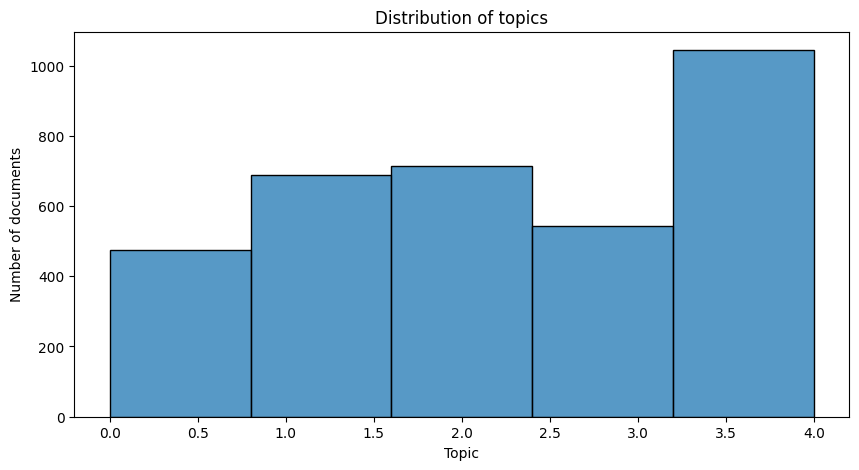

In [7]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0) #once I can run zeroth it, change n_components to something else
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [8]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## FLSA-W

In [9]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [10]:


# create a FLSA-W model (based on the previous iteration, we can conclude that 5 topics is best)
# We continue with 5 topics since we notice the coherence is highest, and the diversity is also good (but not the highest)
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)

In [11]:
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0005*"gmt" + 0.0004*"outnumbered" + 0.0004*"performers" + 0.0003*"settle" + 0.0003*"slumped" + 0.0003*"gainers" + 0.0003*"dax" + 0.0003*"strategiesit" + 0.0003*"aug" + 0.0003*"advancers"'), (1, '0.0017*"com" + 0.0017*"nvda" + 0.0017*"nvidia" + 0.0015*"intc" + 0.0015*"advanced" + 0.0015*"broader" + 0.0015*"nasdaq" + 0.0015*"rank" + 0.0015*"shares" + 0.0014*"believe"'), (2, '0.0002*"premarket" + 0.0002*"nasdaq" + 0.0002*"also" + 0.0002*"market" + 0.0002*"new" + 0.0002*"company" + 0.0002*"reiterates" + 0.0002*"one" + 0.0002*"time" + 0.0001*"cites"'), (3, '0.0103*"book" + 0.0092*"evolution" + 0.0087*"books" + 0.0084*"richard" + 0.0075*"science" + 0.0069*"certainty" + 0.0066*"modern" + 0.0064*"professor" + 0.0053*"beliefs" + 0.0049*"mind"'), (4, '0.0008*"traded" + 0.0007*"reuters" + 0.0007*"worst" + 0.0006*"previously" + 0.0006*"composite" + 0.0006*"ltd" + 0.0006*"lowest" + 0.0006*"donald" + 0.0006*"proven" + 0.0006*"sporting"')]


## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [12]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['gmt', 'outnumbered', 'performers', 'settle', 'slumped', 'gainers', 'dax', 'strategiesit', 'aug', 'advancers']
['com', 'nvda', 'nvidia', 'intc', 'advanced', 'broader', 'nasdaq', 'rank', 'shares', 'believe']
['premarket', 'nasdaq', 'also', 'market', 'new', 'company', 'reiterates', 'one', 'time', 'cites']
['book', 'evolution', 'books', 'richard', 'science', 'certainty', 'modern', 'professor', 'beliefs', 'mind']
['traded', 'reuters', 'worst', 'previously', 'composite', 'ltd', 'lowest', 'donald', 'proven', 'sporting']
0.46609810989969847
0.98
0.4567761477017045


In [13]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)

0.48413451396582863


In [14]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

0.68


In [15]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

0.3292114694967635


## Elbow plots (FLSA-W and LDA)

1
2
3
4
5
6
7
8
9
10


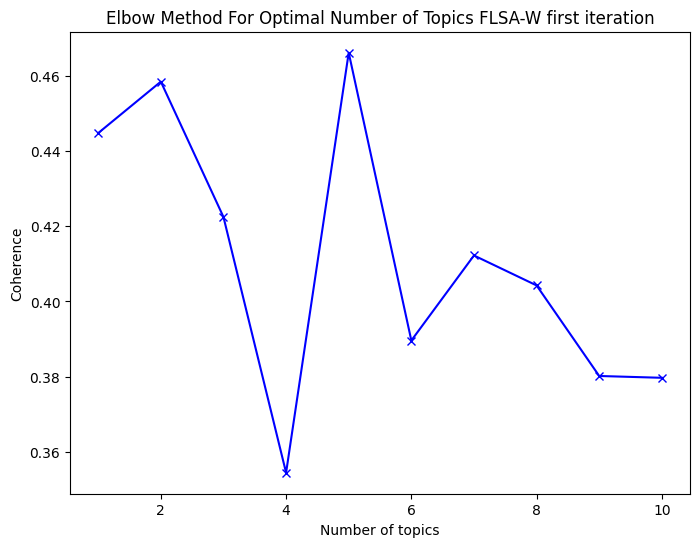

In [16]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get coherence
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W first iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


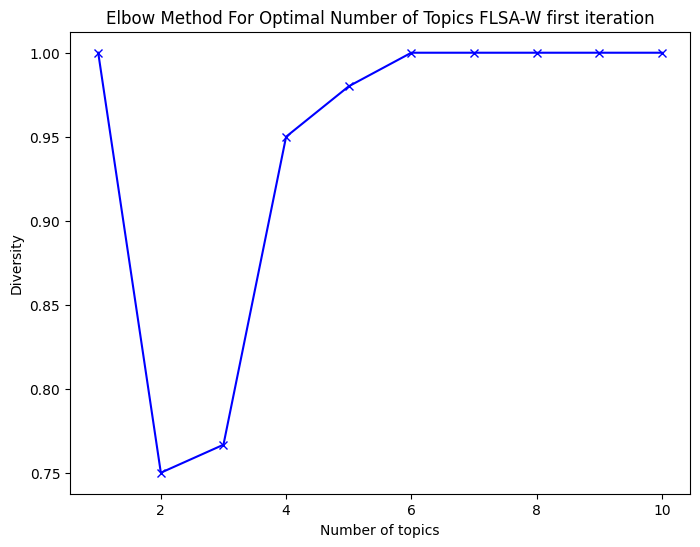

In [17]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W first iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


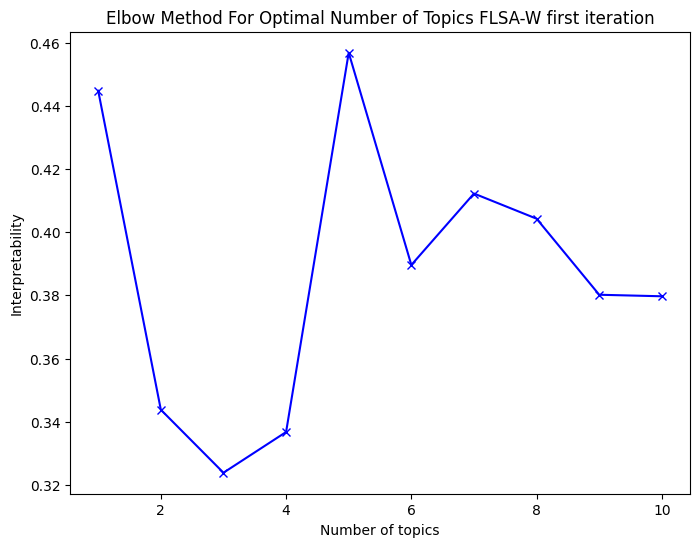

In [18]:
#elbow plot for interpretability
range_n_topics = range(1, 11)
#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    print(i)
    interpretability =  coherences[i-1]*diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W first iteration')
plt.show()

## LDA

1
2
3
4
5
6
7
8
9
10


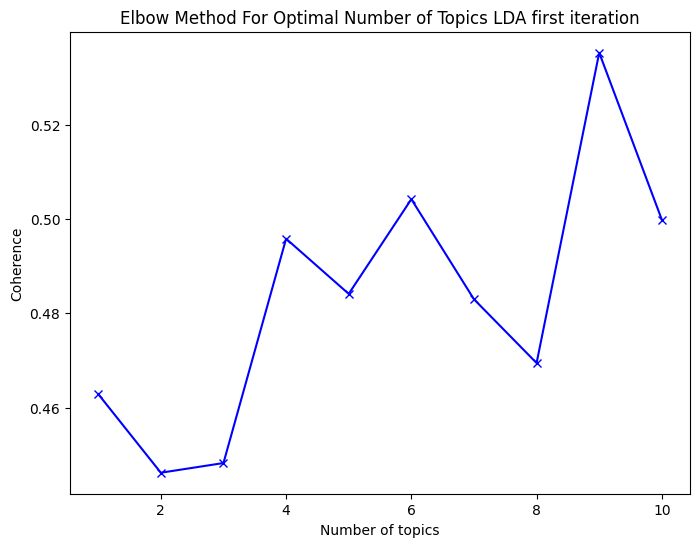

In [19]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get coherence
    topics = get_topics(lda, vectorizer, 10)

    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics LDA first iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


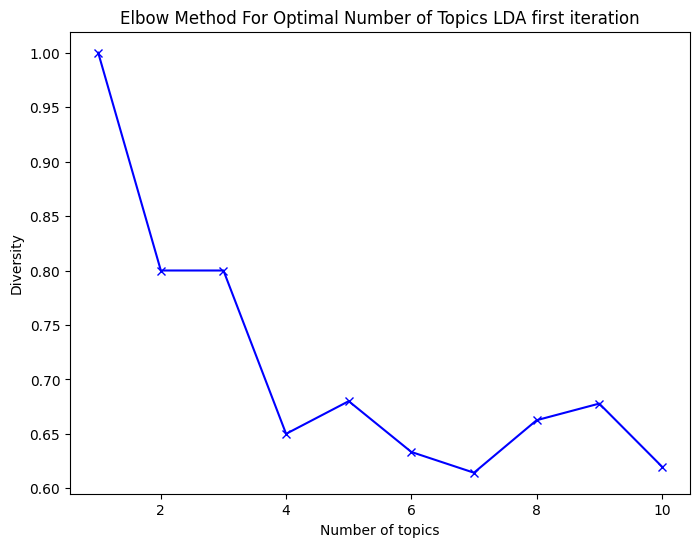

In [20]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get diversity
    topics = get_topics(lda, vectorizer, 10)

    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics LDA first iteration')
plt.show()

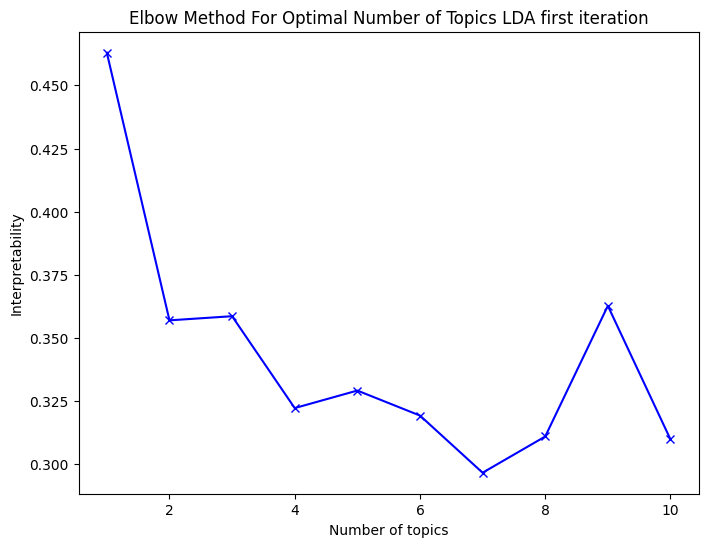

In [21]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics LDA first iteration')
plt.show()

They remain stable. It would be interesting to write a discussion. (there is little variation why?)

## Bert Topic

In [22]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



c:\Users\bvits\OneDrive\Desktop\2024\Uni\NLP\package install\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{-1: [('zacks', 0.007965652417892457),
  ('nasdaq', 0.007900404165344713),
  ('year', 0.00780652685993561),
  ('stocks', 0.007804038112835517),
  ('nvidia', 0.007374932867169882),
  ('market', 0.0073261080415385),
  ('earnings', 0.007093457473016033),
  ('company', 0.0070623560053020675),
  ('growth', 0.006731502381316697),
  ('stock', 0.006591755437570983)],
 0: [('million', 0.025841269325398132),
  ('quarter', 0.022468087120299508),
  ('revenues', 0.020422532473192572),
  ('year', 0.019138988009032337),
  ('company', 0.017724646467290762),
  ('zacks', 0.017591145277379015),
  ('cents', 0.01569721084690687),
  ('consensus', 0.014185591261184342),
  ('estimate', 0.014113167005176916),
  ('rank', 0.013590537538111134)],
 1: [('amd', 0.06078734558508657),
  ('graphics', 0.02240602607609076),
  ('radeon', 0.021385072723375823),
  ('gpu', 0.020320337046467647),
  ('ryzen', 0.017706163879811786),
  ('processors', 0.015316863255181895),
  ('epyc', 0.014551901231011006),
  ('micro', 0.0138660

In [23]:
print(topic_matrix)

    Topic  Count                                Name  \
0      -1   1122         -1_zacks_nasdaq_year_stocks   
1       0    170     0_million_quarter_revenues_year   
2       1    124           1_amd_graphics_radeon_gpu   
3       2     79  2_driving_self_autonomous_vehicles   
4       3     72         3_china_chinese_trade_trump   
..    ...    ...                                 ...   
73     72     11             72_losers_ndls_read_ttd   
74     73     11          73_traded_gmt_seven_lowest   
75     74     10     74_investment_zacks_year_fiscal   
76     75     10        75_percent_bernanke_fed_moon   
77     76     10   76_tsmc_smartphone_taiwan_percent   

                                       Representation  \
0   [zacks, nasdaq, year, stocks, nvidia, market, ...   
1   [million, quarter, revenues, year, company, za...   
2   [amd, graphics, radeon, gpu, ryzen, processors...   
3   [driving, self, autonomous, vehicles, car, car...   
4   [china, chinese, trade, trump, huawei,

In [24]:
bert_topic.visualize_heatmap(n_clusters=15)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_million_quarter_revenues, 10_tech_etf_fang,
                    17_analyst_zacks_reports, 20_million_revenues_quarter,
                    41_estimize_quarter_earnings, 44_earnings_shares_years,
                    74_investment_zacks_year, 1_amd_graphics_radeon,
                    12_gaming_quarter_year, 18_nvidia_nvda_gaming,
                    38_nvidia_revenue_billion, 47_nvidia_center_micron,
                    69_miners_cryptocurrency_cr..., 2_driving_self_autonomous,
                    43_qualcomm_commission_pate..., 68_baidu_apollo_driving,
                    3_china_chinese_trade, 13_bitcoin_blockchain_crypt...,
                    49_semiconductor_china_chip, 60_coronavirus_virus_might,
                    4_semiconductor_earnings_etf, 6_apple_iphone_year,
                    29_intel_swan_chips, 32_micron_mu_dram, 66_nand_dram_micron,
                    76_tsmc_smartphone_taiwan, 5_tracey_podcast_value,
                    8_performers_close_inc, 11_nyse_dow_closed,
                    14_walmart_might_wmt, 19_might_week_market,
                    22_futures_et_points, 24_trade_china_trump,
                    28_day_trading_call, 31_oil_crude_prices,
                    33_resistance_around_level, 53_percent_reuters_randewich,
                    62_market_week_good, 63_futures_et_points,
                    67_forecasts_oil_index, 75_percent_bernanke_fed,
                    7_target_nvidia_rating, 30_revenue_eps_com,
                    9_resistance_roku_towards, 21_stock_nasdaq_investing,
                    27_inc_nyse_nasdaq, 48_trader_today_editor,
                    15_driving_self_autonomous, 36_rtx_gaming_ray,
                    51_cloud_instances_ai, 65_games_stadia_game,
                    16_facebook_users_user, 37_ai_robotics_ml,
                    70_esports_game_activision, 23_traded_gmt_seven,
                    26_traded_gmt_seven, 40_traded_gmt_seven, 45_traded_gmt_seven,
                    50_traded_gmt_seven, 52_traded_gmt_seven, 73_traded_gmt_seven,
                    25_cadence_design_ansys, 35_mellanox_ethernet_marvell,
                    39_intel_ai_israel, 55_hp_intel_dell,
                    56_microsoft_google_azure, 58_qualcomm_chips_chip,
                    59_western_digital_storage, 64_storage_pure_flashblade,
                    71_google_alphabet_android, 34_us_targets_scenario,
                    46_percent_dollar_yield, 54_yesterday_nyse_week,
                    57_rallied_australian_climbed, 42_earnings_greater_growth,
                    61_estimates_earnings_members, 72_losers_ndls_read],
              'xaxis': 'x',
              'y': [0_million_quarter_revenues, 10_tech_etf_fang,
                    17_analyst_zacks_reports, 20_million_revenues_quarter,
                    41_estimize_quarter_earnings, 44_earnings_shares_years,
                    74_investment_zacks_year, 1_amd_graphics_radeon,
                    12_gaming_quarter_year, 18_nvidia_nvda_gaming,
                    38_nvidia_revenue_billion, 47_nvidia_center_micron,
                    69_miners_cryptocurrency_cr..., 2_driving_self_autonomous,
                    43_qualcomm_commission_pate..., 68_baidu_apollo_driving,
                    3_china_chinese_trade, 13_bitcoin_blockchain_crypt...,
                    49_semiconductor_china_chip, 60_coronavirus_virus_might,
                    4_semiconductor_earnings_etf, 6_apple_iphone_year,
                    29_intel_swan_chips, 32_micron_mu_dram, 66_nand_dram_micron,
                    76_tsmc_smartphone_taiwan, 5_tracey_podcast_value,
                    8_performers_close_inc, 11_nyse_dow_closed,
                    14_walmart_might_wmt, 19_might_week_market,
                    22_futures_et_points, 24_trade_china_tru

In [25]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1122,-1_zacks_nasdaq_year_stocks,"[zacks, nasdaq, year, stocks, nvidia, market, ...",[immediate releasechicago il jan zacks com ann...
1,0,170,0_million_quarter_revenues_year,"[million, quarter, revenues, year, company, za...",[keeping earnings streak alive palo alto netwo...
2,1,124,1_amd_graphics_radeon_gpu,"[amd, graphics, radeon, gpu, ryzen, processors...",[month since last earnings report advanced mic...
3,2,79,2_driving_self_autonomous_vehicles,"[driving, self, autonomous, vehicles, car, car...",[intel corporation nasdaq intc recent deal win...
4,3,72,3_china_chinese_trade_trump,"[china, chinese, trade, trump, huawei, compani...",[nearly two year long trade related conflict u...
5,4,68,4_semiconductor_earnings_etf_beta,"[semiconductor, earnings, etf, beta, score, in...",[semiconductor corner broad technology market ...
6,5,64,5_tracey_podcast_value_stocks,"[tracey, podcast, value, stocks, investment, z...",[immediate releasechicago il january zacks mar...
7,6,63,6_apple_iphone_year_billion,"[apple, iphone, year, billion, services, quart...",[earnings season heats wall street watching ap...
8,7,61,7_target_nvidia_rating_price,"[target, nvidia, rating, price, raises, previo...",[nvidia nasdaq nvda reported results yesterday...
9,8,61,8_performers_close_inc_rose,"[performers, close, inc, rose, settle, points,...",[investing com u stocks lower close thursday l...


In [26]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_zacks_nasdaq_year_stocks
['immediate releasechicago il jan zacks com announces list stocks featured analyst blog every day zacks equity research analysts discuss latest news events impacting stocks financial markets stocks recently featured blog include nvidia nasdaq nvda amazon nasdaq amzn microsoft nasdaq msft alibaba nyse baba today zacks promoting buy stock recommendations highlights thursday analyst blog buy nvidia ahead ces sunday night nvidia founder ceo jensen huang take stage kick year international consumer electronics show latest fortune businessperson year present company breakthroughs automotive technology one several growth catalysts management believes lead nvidia top technology world santa clara california based chip making giant specializes high performance graphics processing units gpus used pc gamers emerged pioneer several growing fields including self driving cars artificial intelligence investors rewarded nvidia innovations stock wall street darling gained past

In [27]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:10].to_list()
print(rep_docs)




[['million', 'quarter', 'revenues', 'year', 'company', 'zacks', 'cents', 'consensus', 'estimate', 'rank'], ['amd', 'graphics', 'radeon', 'gpu', 'ryzen', 'processors', 'epyc', 'micro', 'year', 'intel'], ['driving', 'self', 'autonomous', 'vehicles', 'car', 'cars', 'vehicle', 'tesla', 'mobileye', 'said'], ['china', 'chinese', 'trade', 'trump', 'huawei', 'companies', 'tariffs', 'war', 'technology', 'said'], ['semiconductor', 'earnings', 'etf', 'beta', 'score', 'industry', 'zacks', 'semiconductors', 'rank', 'stock'], ['tracey', 'podcast', 'value', 'stocks', 'investment', 'zacks', 'stock', 'ryniec', 'episode', 'momentum'], ['apple', 'iphone', 'year', 'billion', 'services', 'quarter', 'zacks', 'company', 'google', 'earnings'], ['target', 'nvidia', 'rating', 'price', 'raises', 'previously', 'analyst', 'read', 'premarket', 'reiterates'], ['performers', 'close', 'inc', 'rose', 'settle', 'points', 'fell', 'nyse', 'nasdaq', 'worst']]


In [28]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs[0:4])
)


0.7592993717567268


In [29]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs[0:4]))

0.95


1
2
3
4
5
6
7
8
9
10


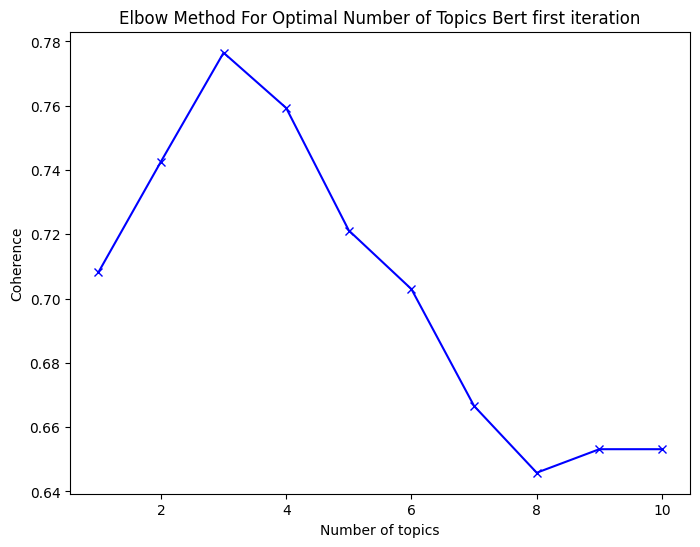

In [30]:
#elbow plot for coherence

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    rep_docs[0:n_topics])
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics Bert first iteration')
plt.show()


topic

1
2
3
4
5
6
7
8
9
10


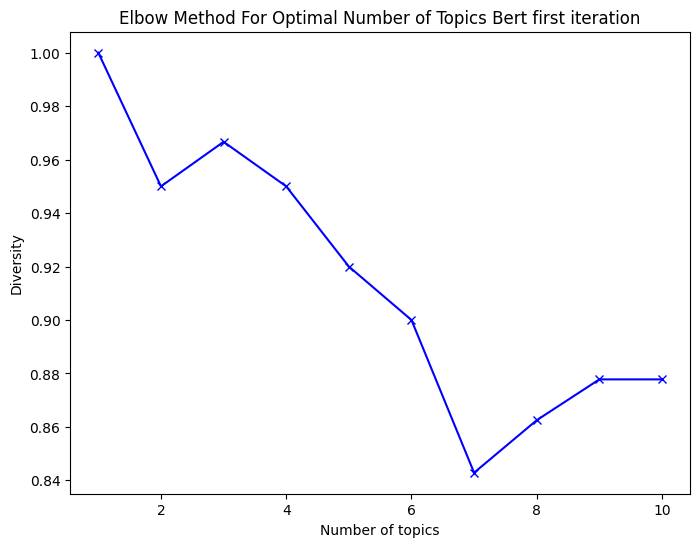

In [31]:
#elbow plot for diversity

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #get diversity
    diversity = flsaW.get_diversity_score(rep_docs[0:n_topics])
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics Bert first iteration')
plt.show()

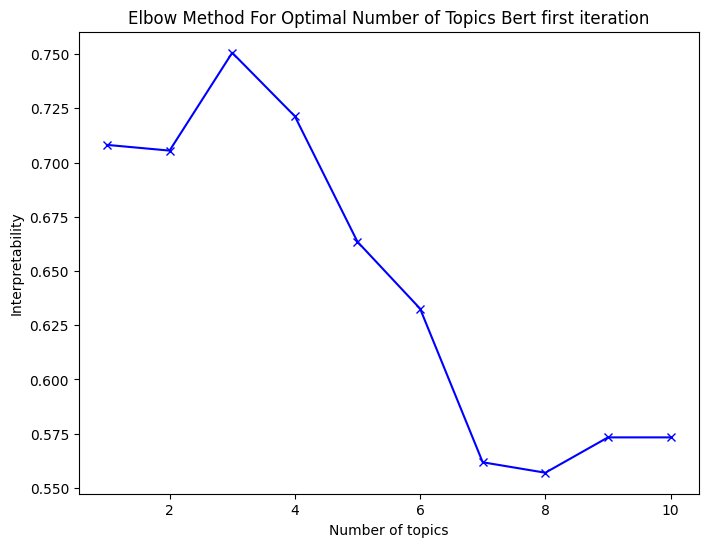

In [32]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics Bert first iteration')
plt.show()